# Machine Learning Project – Predicting Pit-Stop Events in Formula 1

In this project, we aim to predict whether a Formula 1 driver will perform a pit-stop on the current lap using only telemetry data available during the race. Pit-stop decisions play a crucial role in race strategy, directly impacting tyre performance, track position, and overall race outcome.

The prediction task is formulated as a binary classification problem, where the target variable indicates the presence or absence of a pit-stop on a given lap. The dataset contains more than 580,000 laps collected from multiple Formula 1 seasons. However, pit-stop events represent less than 2% of the data, making this a highly imbalanced and challenging machine learning problem.

Throughout this notebook, we follow a complete machine learning workflow: data preparation, exploratory data analysis, feature engineering, model training, and evaluation. Special attention is given to understanding the limitations of the dataset and interpreting the results using metrics adapted to rare-event prediction.

## Data Loading and Dataset Construction

The raw data used in this project comes from multiple CSV files containing heterogeneous information such as race metadata, lap times, pit-stop records, drivers, circuits, and per-lap telemetry. These files are originally distributed across several folders and races.

The first step consists in consolidating all relevant sources into a single unified dataset at the lap level. This involves:
- selecting only the tables required for pit-stop prediction,
- cleaning irrelevant or redundant columns,
- correcting data types,
- and merging all tables using common identifiers such as raceId, driverId, and circuitId.

At the end of this step, each row of the dataset corresponds to a single lap completed by a driver, enriched with telemetry information and a binary indicator specifying whether a pit-stop occurred on that lap.


In [1]:
import pandas as pd
import glob
import os
races = pd.read_csv("races.csv")
races["race_name_clean"] = races["name"].str.lower().str.replace(" ", "_").str.replace("-", "_")


In [2]:
files = glob.glob("lap_data/*.csv")

lap_dfs = []

for f in files:
    df = pd.read_csv(f)
    
    race_name = os.path.basename(f).replace(".csv", "")
    race_name_clean = race_name.lower().replace(" ", "_").replace("-", "_")

    df["race_name"] = race_name
    df["race_name_clean"] = race_name_clean
    
    lap_dfs.append(df)

lap_data = pd.concat(lap_dfs, ignore_index=True)

print("Lap_data shape :", lap_data.shape)


Lap_data shape : (23674, 11)


In [3]:
lap_data = lap_data.merge(
    races[["raceId", "race_name_clean"]],
    on="race_name_clean",
    how="left"
)

print("Merged shape :", lap_data.shape)


Merged shape : (788568, 12)


In [4]:
lap_data.to_csv("all_lap_data.csv", index=False)
print("Saved as all_lap_data.csv")


Saved as all_lap_data.csv


In [5]:
import pandas as pd

lap_data = pd.read_csv("all_lap_data.csv")
circuits = pd.read_csv("circuits.csv")
constructors = pd.read_csv("constructors.csv")
drivers = pd.read_csv("drivers.csv")
lap_times = pd.read_csv("lap_times.csv")
pit_stops = pd.read_csv("pit_stops.csv")
races = pd.read_csv("races.csv")


In [6]:
lap_data.info()
lap_data.describe()

lap_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788568 entries, 0 to 788567
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   DriverNumber     788568 non-null  int64  
 1   Driver           788568 non-null  object 
 2   LapNumber        788568 non-null  float64
 3   Compound         788568 non-null  object 
 4   TyreLife         788568 non-null  float64
 5   Sector1Time      774277 non-null  float64
 6   Sector2Time      787724 non-null  float64
 7   Sector3Time      787324 non-null  float64
 8   LapTime          784409 non-null  float64
 9   race_name        788568 non-null  object 
 10  race_name_clean  788568 non-null  object 
 11  raceId           788568 non-null  int64  
dtypes: float64(6), int64(2), object(4)
memory usage: 72.2+ MB


,DriverNumber,Driver,LapNumber,Compound,TyreLife,Sector1Time,Sector2Time,Sector3Time,LapTime,race_name,race_name_clean,raceId
0,55,SAI,1.0,MEDIUM,1.0,NaN,18.533,35.573,88.375,Australian_Grand_Prix,australian_grand_prix,1
1,55,SAI,1.0,MEDIUM,1.0,NaN,18.533,35.573,88.375,Australian_Grand_Prix,australian_grand_prix,18
2,55,SAI,1.0,MEDIUM,1.0,NaN,18.533,35.573,88.375,Australian_Grand_Prix,australian_grand_prix,36
3,55,SAI,1.0,MEDIUM,1.0,NaN,18.533,35.573,88.375,Australian_Grand_Prix,australian_grand_prix,55
4,55,SAI,1.0,MEDIUM,1.0,NaN,18.533,35.573,88.375,Australian_Grand_Prix,australian_grand_prix,71


In [7]:
lap_data.isnull().sum()

DriverNumber           0
Driver                 0
LapNumber              0
Compound               0
TyreLife               0
Sector1Time        14291
Sector2Time          844
Sector3Time         1244
LapTime             4159
race_name              0
race_name_clean        0
raceId                 0
dtype: int64

In [8]:

cols_to_drop = [
    "Driver",            
    "race_name_clean"    
]
cols_to_drop = [c for c in cols_to_drop if c in lap_data.columns]

lap_data = lap_data.drop(columns=cols_to_drop)


print("Colonnes restantes :", lap_data.columns.tolist())
print("Shape après drop :", lap_data.shape)


Colonnes restantes : ['DriverNumber', 'LapNumber', 'Compound', 'TyreLife', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'LapTime', 'race_name', 'raceId']
Shape après drop : (788568, 10)


In [9]:
lap_data["LapNumber"] = lap_data["LapNumber"].astype(int)
lap_data["raceId"] = lap_data["raceId"].astype(int)
lap_data["Compound"] = lap_data["Compound"].astype("category")

lap_data.dtypes

for col in ["Sector1Time", "Sector2Time", "Sector3Time"]:
    if col in lap_data.columns:
        lap_data[col] = lap_data[col].fillna(lap_data[col].mean())

if "LapTime" in lap_data.columns:
    lap_data["LapTime"] = lap_data["LapTime"].fillna(lap_data["LapTime"].mean())

lap_data.isnull().sum()


DriverNumber    0
LapNumber       0
Compound        0
TyreLife        0
Sector1Time     0
Sector2Time     0
Sector3Time     0
LapTime         0
race_name       0
raceId          0
dtype: int64

In [10]:
pit_stops.info()
pit_stops.describe()
pit_stops.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11371 entries, 0 to 11370
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   raceId        11371 non-null  int64 
 1   driverId      11371 non-null  int64 
 2   stop          11371 non-null  int64 
 3   lap           11371 non-null  int64 
 4   time          11371 non-null  object
 5   duration      11371 non-null  object
 6   milliseconds  11371 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 622.0+ KB


,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,17:05:23,26.898,26898
1,841,30,1,1,17:05:52,25.021,25021
2,841,17,1,11,17:20:48,23.426,23426
3,841,4,1,12,17:22:34,23.251,23251
4,841,13,1,13,17:24:10,23.842,23842


In [11]:
pit_stops.isnull().sum()

raceId          0
driverId        0
stop            0
lap             0
time            0
duration        0
milliseconds    0
dtype: int64

In [12]:
pit_stops = pit_stops.drop(columns=["time", "duration"])
pit_stops["milliseconds"] = pit_stops["milliseconds"].astype(float)
print(pit_stops.dtypes)
pit_stops.head()


raceId            int64
driverId          int64
stop              int64
lap               int64
milliseconds    float64
dtype: object


,raceId,driverId,stop,lap,milliseconds
0,841,153,1,1,26898.0
1,841,30,1,1,25021.0
2,841,17,1,11,23426.0
3,841,4,1,12,23251.0
4,841,13,1,13,23842.0


In [13]:
races.info()
races.describe()
races.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   raceId       1125 non-null   int64 
 1   year         1125 non-null   int64 
 2   round        1125 non-null   int64 
 3   circuitId    1125 non-null   int64 
 4   name         1125 non-null   object
 5   date         1125 non-null   object
 6   time         1125 non-null   object
 7   url          1125 non-null   object
 8   fp1_date     1125 non-null   object
 9   fp1_time     1125 non-null   object
 10  fp2_date     1125 non-null   object
 11  fp2_time     1125 non-null   object
 12  fp3_date     1125 non-null   object
 13  fp3_time     1125 non-null   object
 14  quali_date   1125 non-null   object
 15  quali_time   1125 non-null   object
 16  sprint_date  1125 non-null   object
 17  sprint_time  1125 non-null   object
dtypes: int64(4), object(14)
memory usage: 158.3+ KB


,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


In [14]:
races.isnull().sum()


raceId         0
year           0
round          0
circuitId      0
name           0
date           0
time           0
url            0
fp1_date       0
fp1_time       0
fp2_date       0
fp2_time       0
fp3_date       0
fp3_time       0
quali_date     0
quali_time     0
sprint_date    0
sprint_time    0
dtype: int64

In [15]:
races = races.replace("\\N", pd.NA)
cols_to_drop = [
    "url",
    "fp1_date","fp1_time",
    "fp2_date","fp2_time",
    "fp3_date","fp3_time",
    "quali_date","quali_time",
    "sprint_date","sprint_time"
]

cols_to_drop = [c for c in cols_to_drop if c in races.columns]
races = races.drop(columns=cols_to_drop)

races["raceId"] = races["raceId"].astype(int)
races["year"] = races["year"].astype(int)
races["round"] = races["round"].astype(int)
races["circuitId"] = races["circuitId"].astype(int)

races["date"] = pd.to_datetime(races["date"], errors="coerce")

print(races.dtypes)
races.head()


raceId                int32
year                  int32
round                 int32
circuitId             int32
name                 object
date         datetime64[ns]
time                 object
dtype: object


,raceId,year,round,circuitId,name,date,time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00


In [16]:
circuits.info()
circuits.describe()
circuits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   circuitId   77 non-null     int64  
 1   circuitRef  77 non-null     object 
 2   name        77 non-null     object 
 3   location    77 non-null     object 
 4   country     77 non-null     object 
 5   lat         77 non-null     float64
 6   lng         77 non-null     float64
 7   alt         77 non-null     int64  
 8   url         77 non-null     object 
dtypes: float64(2), int64(2), object(5)
memory usage: 5.5+ KB


,circuitId,circuitRef,name,location,country,lat,lng,alt,url
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...
3,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcel...
4,5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130,http://en.wikipedia.org/wiki/Istanbul_Park


In [17]:
circuits.isnull().sum()

circuitId     0
circuitRef    0
name          0
location      0
country       0
lat           0
lng           0
alt           0
url           0
dtype: int64

In [18]:
circuits = circuits.replace("\\N", pd.NA)  

cols_to_drop = ["circuitRef", "url"]

circuits = circuits.drop(columns=[c for c in cols_to_drop if c in circuits.columns])

circuits["circuitId"] = circuits["circuitId"].astype(int)

circuits["lat"] = circuits["lat"].astype(float)
circuits["lng"] = circuits["lng"].astype(float)
circuits["alt"] = circuits["alt"].astype(float)

print(circuits.dtypes)
circuits.head()


circuitId      int32
name          object
location      object
country       object
lat          float64
lng          float64
alt          float64
dtype: object


,circuitId,name,location,country,lat,lng,alt
0,1,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10.0
1,2,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18.0
2,3,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7.0
3,4,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109.0
4,5,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130.0


In [19]:
drivers.info()
drivers.describe()
drivers.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   driverId     861 non-null    int64 
 1   driverRef    861 non-null    object
 2   number       861 non-null    object
 3   code         861 non-null    object
 4   forename     861 non-null    object
 5   surname      861 non-null    object
 6   dob          861 non-null    object
 7   nationality  861 non-null    object
 8   url          861 non-null    object
dtypes: int64(1), object(8)
memory usage: 60.7+ KB


,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [20]:
drivers.isnull().sum()

driverId       0
driverRef      0
number         0
code           0
forename       0
surname        0
dob            0
nationality    0
url            0
dtype: int64

In [21]:
drivers = drivers.replace("\\N", pd.NA)
cols_to_drop = [
    "driverRef",
    "number",
    "code",
    "forename",
    "surname",
    "nationality",
    "url"
]
drivers = drivers.drop(columns=[c for c in cols_to_drop if c in drivers.columns])
drivers["driverId"] = drivers["driverId"].astype(int)
drivers["dob"] = pd.to_datetime(drivers["dob"], errors="coerce")

print(drivers.dtypes)
drivers.head()


driverId             int32
dob         datetime64[ns]
dtype: object


,driverId,dob
0,1,1985-01-07
1,2,1977-05-10
2,3,1985-06-27
3,4,1981-07-29
4,5,1981-10-19


In [22]:
constructors.info()
constructors.describe()
constructors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   constructorId   212 non-null    int64 
 1   constructorRef  212 non-null    object
 2   name            212 non-null    object
 3   nationality     212 non-null    object
 4   url             212 non-null    object
dtypes: int64(1), object(4)
memory usage: 8.4+ KB


,constructorId,constructorRef,name,nationality,url
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
3,4,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
4,5,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso


In [23]:
constructors.isnull().sum()

constructorId     0
constructorRef    0
name              0
nationality       0
url               0
dtype: int64

In [24]:
constructors = constructors.replace("\\N", pd.NA)

cols_to_drop = ["constructorRef", "name", "nationality", "url"]

constructors = constructors.drop(columns=[c for c in cols_to_drop if c in constructors.columns])
constructors["constructorId"] = constructors["constructorId"].astype(int)

print(constructors.dtypes)
constructors.head()


constructorId    int32
dtype: object


,constructorId
0,1
1,2
2,3
3,4
4,5


In [25]:
lap_times.info()
lap_times.describe()
lap_times.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589081 entries, 0 to 589080
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   raceId        589081 non-null  int64 
 1   driverId      589081 non-null  int64 
 2   lap           589081 non-null  int64 
 3   position      589081 non-null  int64 
 4   time          589081 non-null  object
 5   milliseconds  589081 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 27.0+ MB


,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


In [26]:
lap_times.isnull().sum()

raceId          0
driverId        0
lap             0
position        0
time            0
milliseconds    0
dtype: int64

In [27]:
lap_times = lap_times.replace("\\N", pd.NA)

lap_times = lap_times.drop(columns=["time"])
lap_times["raceId"] = lap_times["raceId"].astype(int)
lap_times["driverId"] = lap_times["driverId"].astype(int)
lap_times["lap"] = lap_times["lap"].astype(int)
lap_times["position"] = lap_times["position"].astype(int)

lap_times["milliseconds"] = lap_times["milliseconds"].astype(int)

print(lap_times.dtypes)
lap_times.head()


raceId          int32
driverId        int32
lap             int32
position        int32
milliseconds    int32
dtype: object


,raceId,driverId,lap,position,milliseconds
0,841,20,1,1,98109
1,841,20,2,1,93006
2,841,20,3,1,92713
3,841,20,4,1,92803
4,841,20,5,1,92342


## Target Variable Definition

The target variable of the classification task is a binary indicator named `pit_this_lap`. It takes the value 1 if a pit-stop occurs on the current lap, and 0 otherwise.

This variable is constructed by matching lap numbers with recorded pit-stop events for each driver and race. A lap is labeled as a pit-stop lap if the driver enters the pit lane during that lap.

Defining the target at the lap level allows us to frame the problem as a real-time prediction task: given the telemetry information available for a lap, the model must estimate the probability that a pit-stop will occur.


In [28]:
import pandas as pd

print("final dataset")

df = lap_times.copy()
print("Base lap_times :", df.shape)

df = df.merge(
    races[["raceId", "year", "round", "circuitId", "name", "date", "time"]],
    on="raceId",
    how="left"
)
print("Après merge races :", df.shape)

df = df.merge(
    circuits[["circuitId", "name", "location", "country", "lat", "lng", "alt"]],
    on="circuitId",
    how="left",
    suffixes=("", "_circuit")
)
print("Après merge circuits :", df.shape)

df = df.merge(
    drivers[["driverId", "dob"]],
    on="driverId",
    how="left"
)
print("Après merge drivers :", df.shape)

pit_stops["pit_this_lap"] = 1

df = df.merge(
    pit_stops[["raceId", "driverId", "lap", "pit_this_lap"]],
    on=["raceId", "driverId", "lap"],
    how="left"
)

df["pit_this_lap"] = df["pit_this_lap"].fillna(0).astype(int)
print("Après merge pit_stop :", df.shape)

cols_to_remove = ["name_circuit"] if "name_circuit" in df.columns else []
df = df.drop(columns=cols_to_remove)

print("\nColonnes finales :")
print(df.columns.tolist())

print("\nShape final du dataset :", df.shape)

df.to_csv("df_final_cleaned.csv", index=False, encoding="utf-8")


🚀 Construction du dataset final...
Base lap_times : (589081, 5)
Après merge races : (589081, 11)
Après merge circuits : (589081, 17)
Après merge drivers : (589081, 18)
Après merge pit_stop : (589081, 19)

Colonnes finales :
['raceId', 'driverId', 'lap', 'position', 'milliseconds', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'location', 'country', 'lat', 'lng', 'alt', 'dob', 'pit_this_lap']

Shape final du dataset : (589081, 18)

🎉 Fichier exporté : df_final_cleaned.csv


## Lap Time Distribution and Pit-Stop Detection

We start the exploratory data analysis by examining the distribution of lap times for pit-stop and non-pit-stop laps. LapTime is expected to be a strong indicator of pit-stop presence, since drivers significantly slow down when entering the pit lane.

This analysis serves two purposes:
- validating the correctness of the pit-stop labels,
- understanding whether LapTime can be used as a predictive signal before a pit-stop.
  
## Sector Times Behaviour Before a Pit-Stop

Sector times provide a more granular view of lap performance and may capture subtle degradation patterns before a pit-stop. We analyse each sector separately to assess whether local slowdowns appear prior to pit entry.


C:\Users\sarah\AppData\Local\Temp\ipykernel_27524\3005874974.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("df_final_cleaned.csv")


Shape après suppression des outliers : (93428, 24)


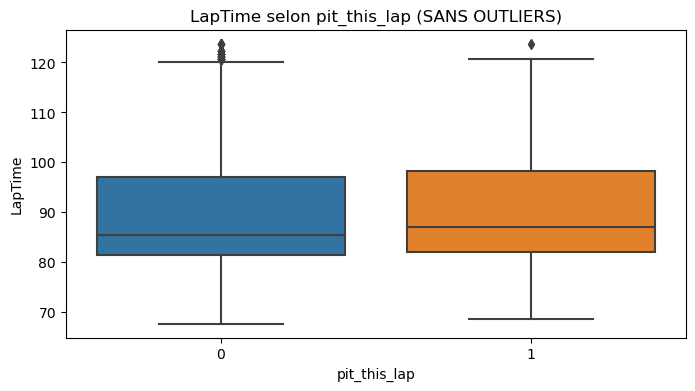

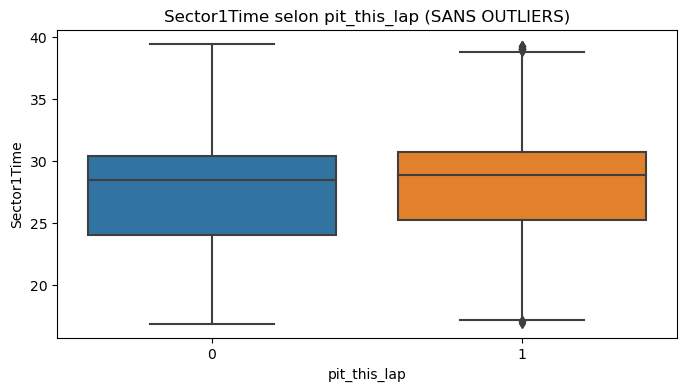

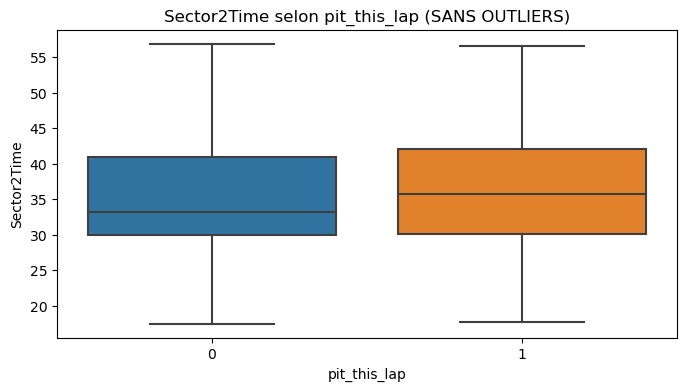

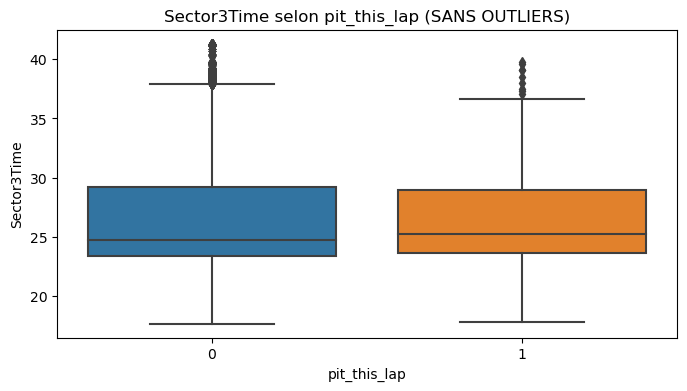

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("df_final_cleaned.csv")
def remove_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[col] >= lower) & (data[col] <= upper)]

# Colonnes à filtrer
cols = ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]

df_clean = df.copy()
for c in cols:
    df_clean = remove_outliers_iqr(df_clean, c)

print("Shape without outlier :", df_clean.shape)


plt.figure(figsize=(8,4))
sns.boxplot(x=df_clean["pit_this_lap"], y=df_clean["LapTime"])
plt.title("LapTime selon pit_this_lap (SANS OUTLIERS)")
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x=df_clean["pit_this_lap"], y=df_clean["Sector1Time"])
plt.title("Sector1Time selon pit_this_lap (SANS OUTLIERS)")
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x=df_clean["pit_this_lap"], y=df_clean["Sector2Time"])
plt.title("Sector2Time selon pit_this_lap (SANS OUTLIERS)")
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x=df_clean["pit_this_lap"], y=df_clean["Sector3Time"])
plt.title("Sector3Time selon pit_this_lap (SANS OUTLIERS)")
plt.show()


The distribution clearly shows that pit-stop laps are associated with a large increase in lap time. This confirms that the target variable is correctly defined. However, this sharp increase occurs during the pit-stop lap itself and not before. As a result, LapTime is highly discriminative for identifying pit-stop laps retrospectively, but it provides little predictive value for anticipating a pit-stop in advance.


Sector 1 shows only minor differences between pit and non-pit laps. The distributions largely overlap, suggesting that Sector 1 carries limited predictive information when considered alone.
Sector 2 exhibits slightly more variability on pit-stop laps. This may be explained by the fact that, on some circuits, pit entry preparation starts during the middle of the lap. Nevertheless, the overlap remains significant, limiting its standalone predictive power.
Sector 3 shows the clearest separation between pit and non-pit laps. Since pit entry is often located near the end of the lap, drivers tend to reduce speed in this sector before entering the pit lane. Although still insufficient on its own, Sector 3 provides complementary information for modelling pit-stop behaviour.



## Tyre Age and Pit-Stop Behaviour

TyreLife represents the number of laps completed on the current set of tyres. Since tyres degrade over time, this variable is expected to be informative for pit-stop prediction.


Shape après suppression des outliers : (100069, 24)


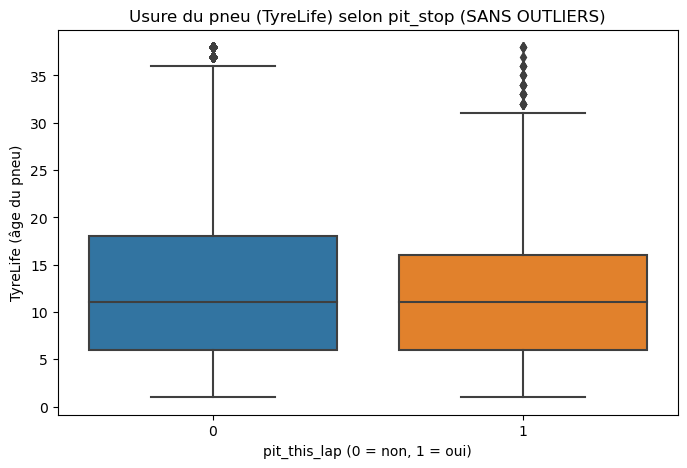

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
def remove_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series[(series >= lower) & (series <= upper)]

df_no_outliers = df[df["TyreLife"].isin(remove_outliers(df["TyreLife"]))]

print("Shape without:", df_no_outliers.shape)

plt.figure(figsize=(8,5))
sns.boxplot(data=df_no_outliers, x="pit_this_lap", y="TyreLife")
plt.title("Usure du pneu (TyreLife) selon pit_stop (SANS OUTLIERS)")
plt.xlabel("pit_this_lap (0 = non, 1 = oui)")
plt.ylabel("TyreLife (âge du pneu)")
plt.show()


Pit-stops tend to occur when tyre age reaches a certain range, typically between 10 and 16 laps. However, there is significant overlap between pit and non-pit laps. This reflects the influence of strategic decisions, early stops, and varying tyre durability across compounds and drivers. TyreLife is informative but not deterministic.


## Correlation Analysis

A correlation matrix is computed to assess linear relationships between numerical variables. The results show generally low correlations, particularly between tyre age and lap performance.

This indicates that pit-stop prediction is inherently nonlinear and cannot be captured by simple threshold-based rules. This observation justifies the use of tree-based models and more advanced feature engineering.


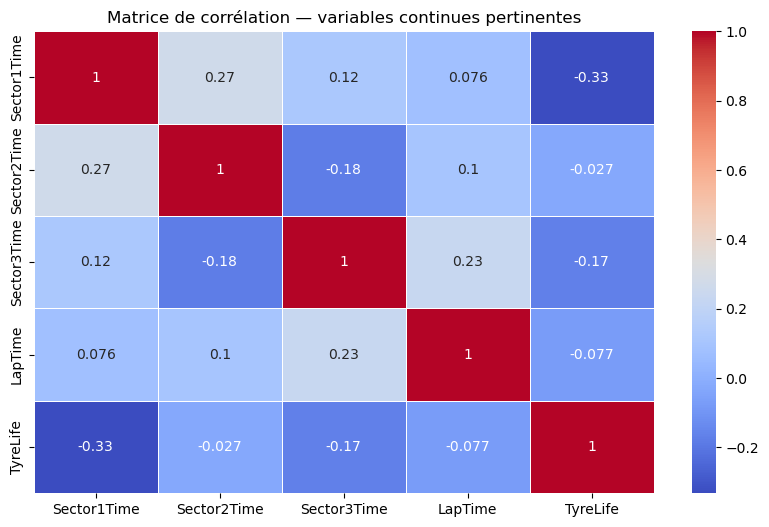

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = ["Sector1Time", "Sector2Time", "Sector3Time", "LapTime", "TyreLife"]

corr = df[cols].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Matrice de corrélation — variables continues pertinentes")
plt.show()


## TyreLife Distribution by Tyre Compound (Outliers Removed)

Tyre degradation is a key factor influencing pit-stop strategy. Different tyre compounds are designed with different durability profiles, which should be reflected in the number of laps completed before a pit-stop.

In order to analyse these differences clearly, we study the distribution of `TyreLife` for each tyre compound. Extreme values are removed beforehand to avoid distortions caused by abnormal situations (very long stints, data inconsistencies, or race incidents). This allows us to focus on representa


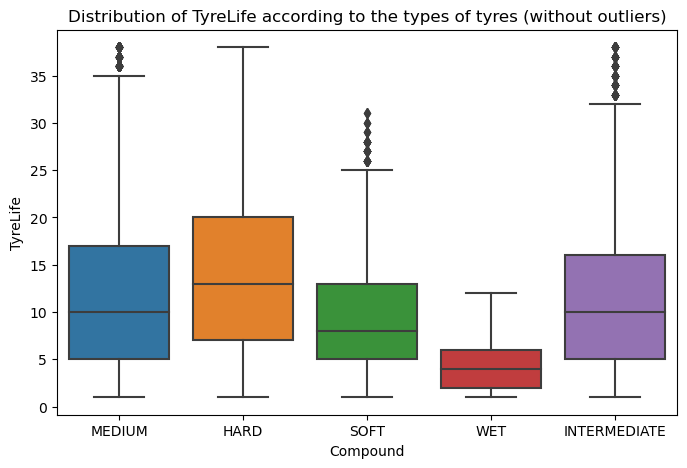

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
df_clean = df[df["TyreLife"].isin(remove_outliers(df["TyreLife"]))]

plt.figure(figsize=(8,5))
sns.boxplot(data=df_clean, x="Compound", y="TyreLife")
plt.title("Distribution of TyreLife according to the types of tyres (without outliers)")
plt.xlabel("Compound")
plt.ylabel("TyreLife")
plt.show()


The boxplot highlights clear differences in tyre longevity across compounds. Hard tyres exhibit the highest median tyre life and the widest distribution, confirming their role as the most durable compound. Medium tyres show intermediate behaviour, while Soft tyres have a significantly shorter lifespan, reflecting their higher grip but faster degradation.

Intermediate and Wet tyres display more variable distributions. Their tyre life depends strongly on race conditions such as weather changes and track evolution, which explains the larger spread and occasional higher values even after outlier removal.

Although tyre compound strongly influences tyre life, there is still a significant overlap between distributions. This indicates that tyre life alone cannot deterministically predict pit-stops, as strategic decisions, race context, and driver behaviour also play a major role. Nevertheless, this analysis confirms that `Compound` and `TyreLife` provide essential contextual information for pit-stop prediction models.


## Tyre Compound and Pit-Stop Frequency

Tyre compound plays a central role in race strategy and directly influences degradation behaviour. We analyse the distribution of pit-stops across different tyre compounds to understand their relationship with pit-stop decisions.


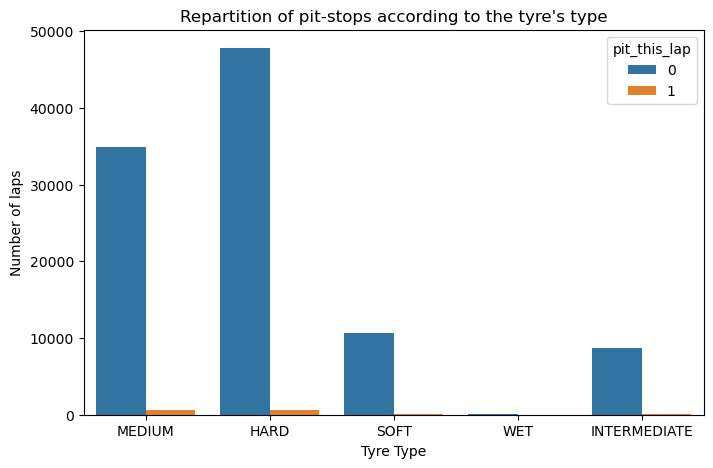

In [39]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="Compound", hue="pit_this_lap")
plt.title("Repartition of pit-stops according to the tyre's type")
plt.xlabel("Tyre Type")
plt.ylabel("Number of laps")
plt.show()


Most laps are driven on Medium and Hard tyres, which is consistent with standard Formula 1 race strategies. Pit-stop frequency remains low across all compounds, confirming the extreme imbalance of the target variable. Compound alone does not predict pit-stops but provides important contextual information.


## Lap Time Degradation Before a Pit-Stop

One of the key hypotheses behind pit-stop decisions is that tyre degradation leads to a gradual loss of performance, which may be observable through increasing lap times. To investigate this effect, we analyse the evolution of lap time degradation as a function of tyre age just before a pit-stop.

The variable ΔLapTime represents the local change in lap time compared to previous laps, capturing short-term performance variations rather than absolute pace. Outliers are removed to focus on representative degradation patterns and avoid distortions caused by extreme race events or data inconsistencies.

Each point corresponds to a lap preceding a pit-stop, and colours indicate the tyre compound in use.


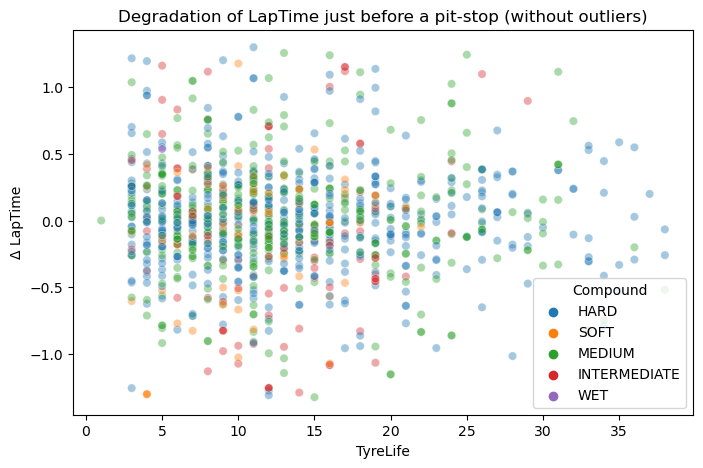

In [41]:
df_sorted = df.sort_values(["driverId", "raceId", "lap"])
df_sorted["LapTime_diff"] = df_sorted.groupby(["driverId","raceId"])["LapTime"].diff()

mask = df_sorted["LapTime_diff"].isin(remove_outliers(df_sorted["LapTime_diff"])) & \
       df_sorted["TyreLife"].isin(remove_outliers(df_sorted["TyreLife"]))

df_clean = df_sorted[mask]

n = len(df_clean[df_clean["pit_this_lap"] == 1])
n_sample = min(4000, n)

sampled = df_clean[df_clean["pit_this_lap"] == 1].sample(n_sample, random_state=0)

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=sampled, x="TyreLife", y="LapTime_diff", hue="Compound", alpha=0.4
)
plt.title("Degradation of LapTime just before a pit-stop (without outliers)")
plt.xlabel("TyreLife")
plt.ylabel("Δ LapTime")
plt.show()



The scatter plot reveals a highly dispersed relationship between tyre age and lap time degradation. As tyre life increases, the variability of ΔLapTime becomes larger, indicating that older tyres tend to produce less predictable performance. Some laps show clear degradation, while others temporarily improve due to factors such as fuel burn-off or changing track conditions.

No clear monotonic trend emerges between TyreLife and ΔLapTime, regardless of the tyre compound. Even for older tyres, lap time degradation remains highly heterogeneous. This confirms that pit-stop decisions cannot be explained by a simple degradation threshold.

The overlap between compounds further highlights the nonlinear and context-dependent nature of pit-stop strategies. While degradation patterns exist, they are subtle, noisy, and strongly influenced by external factors not captured in the dataset. This observation justifies the need for nonlinear models and richer feature engineering when attempting to predict pit-stops from telemetry data alone.


## Analysis of Target Imbalance

Before training any machine learning model, it is essential to analyse the distribution of the target variable. In our case, the target `pit_this_lap` indicates whether a pit-stop occurs on a given lap.

Because pit-stops are rare events in Formula 1 races, we expect a strong imbalance between the two classes. This step aims to quantify this imbalance precisely, both in absolute numbers and in percentages, and to evaluate its potential impact on model training and evaluation.


===== Analyse de l'Imbalanced Target =====

Counts:
pit_this_lap
0    577710
1     11371
Name: count, dtype: int64

Pourcentage (%):
pit_this_lap
0    98.07
1     1.93
Name: proportion, dtype: float64

➡️  Ratio majoritaire/minoritaire : 50.81 : 1

⚠️  ATTENTION : Dataset fortement déséquilibré !


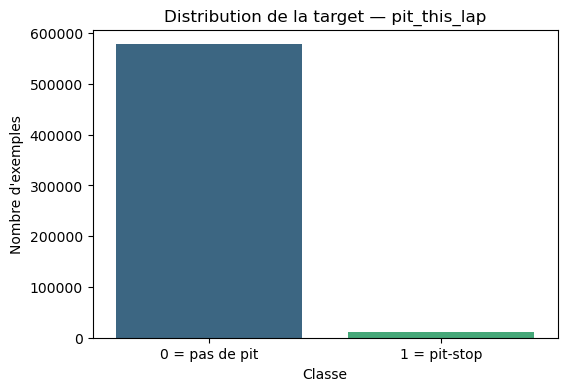

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Analysis of Imbalanced Target")

class_counts = df["pit_this_lap"].value_counts()
print("\nCounts:")
print(class_counts)

class_percent = df["pit_this_lap"].value_counts(normalize=True) * 100
print("\nPourcentage (%):")
print(class_percent.round(3))

major = class_counts.max()
minor = class_counts.min()
ratio = major / minor
print(f"\nRatio majoritaire/minoritaire : {ratio:.2f} : 1")

if ratio > 5:
    print("\nATTENTION : Dataset fortement déséquilibré !")
elif ratio > 2:
    print("\n Léger déséquilibre.")
else:
    print("\nDonnées équilibrées.")
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Distribution de la target — pit_this_lap")
plt.xlabel("Classe")
plt.ylabel("Nombre d'exemples")
plt.xticks([0,1], ["0 = pas de pit", "1 = pit-stop"])
plt.show()


The class distribution confirms that the dataset is extremely imbalanced. The vast majority of laps correspond to non-pit laps, while pit-stop events represent only a very small fraction of the data.

The majority-to-minority ratio exceeds 50:1, which clearly places this problem in a rare-event prediction setting. In such conditions, standard machine learning approaches tend to favour the majority class, often leading to misleadingly high accuracy while failing to detect pit-stop events.

This imbalance is not an error in the dataset but a direct reflection of real race dynamics. However, it imposes strong constraints on model design, metric selection, and decision thresholding, which must be explicitly addressed in the following steps.


The bar plot visually highlights the extreme dominance of the non-pit class. Although this representation may appear trivial, it plays a crucial role in setting realistic expectations for model performance.

In this context, accuracy alone is not a meaningful metric, as a trivial classifier predicting “no pit-stop” on every lap would already achieve more than 98% accuracy. As a result, alternative evaluation metrics such as recall, precision, F1-score, and Precision–Recall AUC must be prioritised.

Some instability or unexpected behaviour observed in later modelling stages is therefore expected and should be interpreted as a consequence of the dataset’s structure rather than implementation errors. This analysis motivates the use of imbalance-aware strategies such as class weighting, threshold tuning, and the exploration of more advanced models.


## Feature Engineering

Raw telemetry variables do not explicitly capture temporal dynamics such as race progression or tyre degradation trends. In order to provide the model with richer and more informative inputs, several engineered features are introduced at the lap level.

These features are designed to normalise driver behaviour across races, capture local performance variations, and introduce track-specific context. All transformations are applied within each driver–race pair to preserve the chronological structure of the data and avoid information leakage across races.


In [51]:
import pandas as pd
import numpy as np

df = pd.read_csv("df_final_cleaned.csv")
df_updated = df

df_updated["Lap_pct"] = (
    df_updated["lap"] /
    df_updated.groupby(["driverId","raceId"])["lap"].transform("max")
)

df_updated["LapTime_diff"] = (
    df_updated.groupby(["driverId","raceId"])["LapTime"].diff()
)
df_updated["TyreLife_norm"] = (
    df_updated["TyreLife"] /
    df_updated.groupby(["driverId","raceId"])["TyreLife"].transform("max")
)

track_mean_sector3 = df_updated.groupby("circuitId")["Sector3Time"].mean()
df_updated["Track_Aggressiveness"] = (
    df_updated["circuitId"].map(track_mean_sector3)
)


C:\Users\sarah\AppData\Local\Temp\ipykernel_27524\2229415435.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("df_final_cleaned.csv")


Four additional features are constructed.

The variable `Lap_pct` represents the relative progression of a lap within a race, normalised by the total number of laps completed by a driver in that race. This feature allows the model to distinguish early, mid, and late race phases independently of race length.

The feature `LapTime_diff` captures short-term variations in performance by computing the difference in lap time between consecutive laps for a given driver and race. This local derivative provides a proxy for pace degradation or improvement that may precede a pit-stop. Missing values at the start of each stint are expected and handled during preprocessing.

The variable `TyreLife_norm` normalises tyre age by the maximum tyre life observed for each driver and race. This transformation reduces inter-race variability and allows the model to compare tyre wear dynamics across different strategies and compounds.

Finally, `Track_Aggressiveness` is introduced as a circuit-level feature, computed as the average Sector 3 time for each circuit. Sector 3 is often associated with pit entry and late-lap behaviour, making it a reasonable proxy for track-specific degradation tendencies. While this feature is a simplified approximation, it provides contextual information that is otherwise absent from the dataset.

These engineered features aim to expose nonlinear and contextual patterns that are not directly observable in the raw telemetry, while remaining computationally tractable for large-scale modelling.


## Feature Selection and Target Definition

At this stage, we define the input features and the target variable used for model training. The target `pit_this_lap` indicates whether a pit-stop occurs on the current lap.

The feature set combines raw telemetry variables, engineered features, and contextual identifiers. This heterogeneous set is designed to capture both performance dynamics (lap times, tyre wear) and contextual information (driver and circuit characteristics) that may influence pit-stop decisions.


In [52]:
# Target
y = df_updated["pit_this_lap"]

X = df_updated[[
    "lap",
    "Lap_pct",
    "LapTime_diff",
    "TyreLife",
    "TyreLife_norm",
    "Track_Aggressiveness",
    "Compound",
    "driverId",
    "circuitId"
]]


The selected numerical features include lap progression indicators, tyre wear variables, and performance degradation proxies. These variables aim to represent the temporal evolution of a stint and local pace variations.

Categorical features such as tyre compound, driver identifier, and circuit identifier are also included. While these variables do not directly encode strategy, they provide contextual information that allows the model to learn driver-specific behaviours and track-dependent characteristics. This choice increases model expressiveness but also introduces additional complexity, which is handled through appropriate preprocessing.


## Train–Test Split Strategy

The dataset is split into training and test sets using an 80/20 ratio. Given the extreme imbalance of the target variable, a stratified split is applied to preserve the original class distribution in both subsets.

This ensures that pit-stop events are present in the test set and that evaluation metrics remain representative of real-world performance.


In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


Stratification is essential in this context, as random splitting without constraint could result in test sets with very few or no pit-stop events. Preserving class proportions allows for more reliable performance evaluation and avoids misleading results.


In [56]:
num_features = ["lap", "Lap_pct", "LapTime_diff",
                "TyreLife", "TyreLife_norm", "Track_Aggressiveness"]

cat_features = ["Compound", "driverId", "circuitId"]  

## Preprocessing Pipeline

The dataset contains both numerical and categorical variables, each requiring different preprocessing steps. To ensure consistency and avoid data leakage, all preprocessing operations are encapsulated within a single pipeline.

Numerical features are imputed using the median to reduce sensitivity to outliers and then standardised to ensure comparable scales. Categorical variables are imputed using the most frequent value and encoded using one-hot encoding. Unknown categories are safely ignored at inference time.


In [60]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

num_features = ["lap", "Lap_pct", "LapTime_diff",
                "TyreLife", "TyreLife_norm", "Track_Aggressiveness"]

cat_features = ["Compound", "driverId", "circuitId"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_features),

        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features)
    ]
)



This preprocessing strategy ensures that all transformations are learned exclusively from the training data and applied identically to the test data. It also allows the model to handle missing values and high-cardinality categorical variables in a robust and scalable manner.


## Model Selection and Configuration

As a baseline model, we use a Random Forest classifier. This choice is motivated by its ability to handle nonlinear interactions, mixed feature types, and complex decision boundaries without strong assumptions on data distribution.

Given the strong class imbalance, class weighting is explicitly enabled so that misclassification of pit-stop laps is penalised more heavily during training.


In [65]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",   
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", model)
])


In [ ]:
pipeline.fit(X_train, y_train)

The preprocessing steps and the classifier are combined into a single pipeline. This design guarantees that all transformations are applied consistently during both training and inference, and simplifies experimentation and model evaluation.

While this baseline model provides a solid starting point, it is not expected to fully solve the pit-stop prediction task. The rarity of pit-stop events, the absence of strategic race context, and the use of static features limit predictive performance. Nevertheless, this pipeline establishes a clear and reproducible framework upon which more advanced models and imbalance-handling strategies can be built.


## Model Evaluation and Interpretation of Results



===== Classification Report =====

              precision    recall  f1-score   support

           0     0.9816    0.9616    0.9715    115543
           1     0.0423    0.0862    0.0568      2274

    accuracy                         0.9447    117817
   macro avg     0.5120    0.5239    0.5142    117817
weighted avg     0.9635    0.9447    0.9539    117817



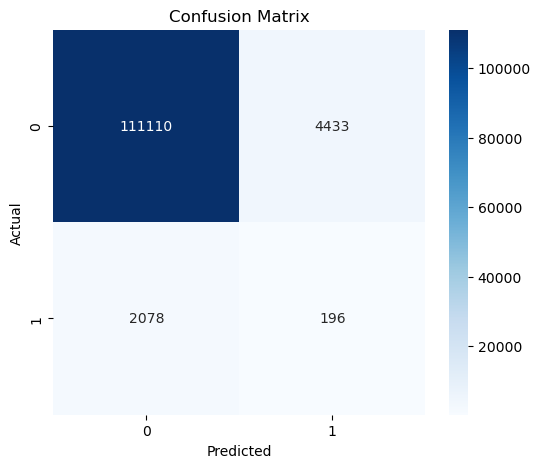


🔥 ROC-AUC : 0.6584



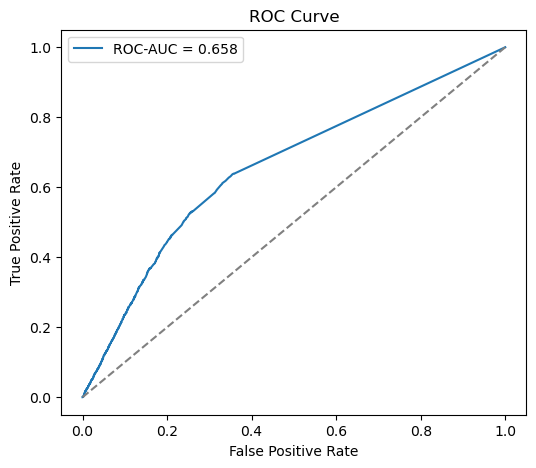

🔥 Precision-Recall AUC : 0.0335



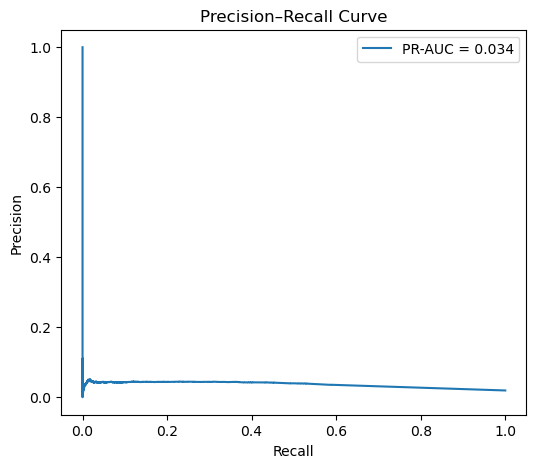


🎯 Meilleur threshold pour F1 (classe 1) : 0.015
🎯 F1-score obtenu : 0.0772


===== Classification Report (threshold optimisé) =====

              precision    recall  f1-score   support

           0     0.9854    0.8384    0.9060    115543
           1     0.0431    0.3698    0.0772      2274

    accuracy                         0.8294    117817
   macro avg     0.5143    0.6041    0.4916    117817
weighted avg     0.9672    0.8294    0.8900    117817



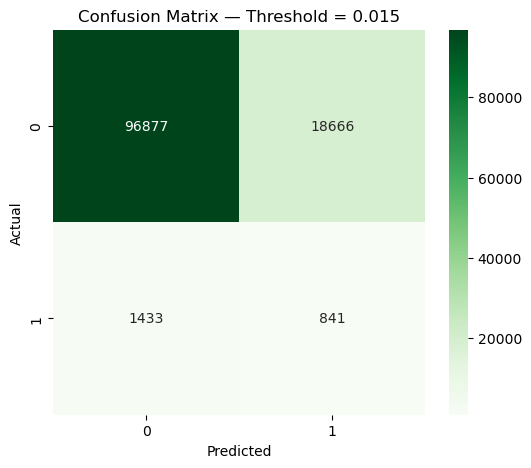

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("\nClassification Report\n")
print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
print(f"\n ROC-AUC : {roc_auc:.4f}\n")

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

pr_auc = average_precision_score(y_test, y_proba)
print(f"🔥 Precision-Recall AUC : {pr_auc:.4f}\n")

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()

best_f1 = 0
best_thresh = 0.5

for thr in np.linspace(0.01, 0.99, 200):
    y_thr = (y_proba >= thr).astype(int)
    from sklearn.metrics import f1_score
    f1 = f1_score(y_test, y_thr, pos_label=1)

    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thr

print(f"\n Meilleur threshold pour F1 (classe 1) : {best_thresh:.3f}")
print(f" F1-score obtenu : {best_f1:.4f}\n")

y_pred_best = (y_proba >= best_thresh).astype(int)

print("\n Classification Report (threshold optimised)\n")
print(classification_report(y_test, y_pred_best, digits=4))

cm2 = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,5))
sns.heatmap(cm2, annot=True, fmt='g', cmap="Greens")
plt.title(f"Confusion Matrix — Threshold = {best_thresh:.3f}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


The performance of the baseline model is evaluated using several complementary metrics and visualisations, which are necessary in the context of an extremely imbalanced classification problem.

The classification report first highlights a strong asymmetry between the two classes. The model performs very well on the majority class (non–pit-stop laps), with high precision and recall, resulting in a global accuracy close to 95%. However, this value is misleading due to the dominance of class 0. For the minority class (pit-stop laps), precision and recall remain low, leading to a weak F1-score. This behaviour is expected in rare-event prediction and confirms that accuracy alone is not an appropriate metric in this setting.

The ROC curve shows an AUC of approximately 0.66, indicating that the model retains some ability to discriminate between pit-stop and non–pit-stop laps. While this score is above random performance, ROC–AUC tends to be optimistic in highly imbalanced datasets, as it gives equal importance to both classes regardless of their prevalence.

The Precision–Recall curve provides a more realistic assessment of model performance on the minority class. The very low PR–AUC value reflects the difficulty of maintaining high precision while increasing recall for pit-stop detection. Even a small number of false positives significantly impacts precision, which explains the rapid drop observed in the curve.

To partially address this limitation, the decision threshold is adjusted to a much lower value than the default. The resulting confusion matrix shows a clear increase in recall for pit-stop events, at the cost of a substantial rise in false positives. This trade-off is inherent to rare-event prediction problems and illustrates that the model does capture useful signal, but requires adapted decision rules.

Overall, these results confirm that the model’s limitations are primarily driven by the structure of the dataset rather than implementation errors. The extreme imbalance, the absence of strategic race context, and the size of the dataset strongly constrain achievable performance. This evaluation therefore serves as a diagnostic step, motivating the exploration of more advanced models, improved imbalance-handling techniques, and richer feature representations in future work.


## Conclusion and Perspectives

This project explored the challenging task of predicting pit-stop events in Formula 1 using only lap-level telemetry data. From the outset, we were confronted with a highly constrained and realistic machine learning problem: pit-stops are rare events, representing less than 2% of all laps, and their occurrence depends not only on measurable performance indicators but also on strategic decisions and race context that are not available in the dataset.

Through extensive data preparation and exploratory analysis, we identified key characteristics of the problem. Lap times, sector times, and tyre age do exhibit meaningful patterns, but these signals are weak, noisy, and highly nonlinear. Tyre degradation alone does not deterministically trigger pit-stops, and significant overlap exists between pit and non-pit laps across all compounds and drivers. These observations explain why simple threshold-based rules or linear models are insufficient for this task.

The machine learning pipeline implemented in this project follows best practices, including robust preprocessing, feature engineering, stratified train–test splitting, and the use of imbalance-aware evaluation metrics. The baseline Random Forest model demonstrates that some predictive signal is present, as reflected by ROC–AUC performance above random. However, Precision–Recall analysis reveals the true difficulty of the task: reliably detecting pit-stop events without generating a large number of false positives remains challenging.

Adjusting the decision threshold improves recall on pit-stop laps, but at the cost of reduced precision. This trade-off is inherent to rare-event prediction problems and highlights the limitations imposed by the dataset rather than flaws in the implementation. Some instability and apparent inconsistencies observed during modelling are therefore expected consequences of the dataset’s size, imbalance, and missing contextual variables.

Despite these limitations, this project provides a solid foundation for future work. Several directions for improvement naturally emerge, including the use of more advanced models better suited to sequential data, alternative imbalance-handling techniques, and richer feature representations capturing temporal dynamics more explicitly. Integrating additional contextual information such as weather conditions, safety car periods, or race strategy would also significantly enhance predictive performance.

Overall, this project offered valuable insight into the realities of applying machine learning to complex, real-world data. Beyond model performance, it highlighted the importance of critical evaluation, metric selection, and transparent interpretation of results under strong constraints. These lessons are essential for any practical machine learning application in high-stakes, data-driven environments.
